# Files IO

In [1]:
# Read all the .pt graph data using torch_geometric from /cwStorage/nodecw_group/jijh/hest_graph_data

import os
import torch
import torch_geometric.data
import numpy as np
import matplotlib.pyplot as plt

# Read all the .pt files in the directory
data_dir = '/cwStorage/nodecw_group/jijh/hest_graph_data'
data_list = []
for file in os.listdir(data_dir):
    if file.endswith('.pt'):
        data_list.append(torch.load(os.path.join(data_dir, file)))

# Print the first data
print(data_list[0])


/tmp/ipykernel_130710/356955504.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_list.append(torch.load(os.path.join(data_dir, file)))


Data(x=[6945, 50], edge_index=[2, 62505], edge_attr=[62505], pos=[6945, 2], sample_ids=[6945], image_paths=[6945])


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Convert the list to dictionary with sample_id as key
data_dict = {}
for data in data_list:
    data_dict[data.sample_ids[0]] = data


# Model

In [3]:
from diffusers import AutoencoderTiny

def get_vae_model(sample_size=512, latent_channels=4, use_pretrained=False, sd_version='v2.1'):
    """
    获取 VAE 模型。
      - use_pretrained=True（默认）：加载预训练的 Tiny AutoEncoder 模型（保持参数为 FP32）。
          sd_version: 'v2.1'（默认）加载适用于 Stable Diffusion v2.1 的 Tiny AutoEncoder，
                      若设置为 'sdxl' 则加载适用于 SDXL 的版本。
      - use_pretrained=False：从头构造新的 Tiny AutoEncoder 模型（采用 TAESD 默认配置）。
    """
    if use_pretrained:
        if sd_version == 'v2.1':
            vae = AutoencoderTiny.from_pretrained("madebyollin/taesd", torch_dtype=torch.float32)
        elif sd_version == 'sdxl':
            vae = AutoencoderTiny.from_pretrained("madebyollin/taesdxl", torch_dtype=torch.float32)
        else:
            raise ValueError("sd_version 需为 'v2.1' 或 'sdxl'")
        print("Loaded pretrained Tiny AutoEncoder model.")
    else:
        # 从头构造 Tiny AutoEncoder 模型，参数取自 TAESD 默认设置
        vae = AutoencoderTiny(
            in_channels=3,
            out_channels=3,
            encoder_block_out_channels=(64, 64, 64, 64),
            decoder_block_out_channels=(64, 64, 64, 64),
            act_fn="relu",
            latent_channels=latent_channels,
            upsampling_scaling_factor=2,
            num_encoder_blocks=(1, 3, 3, 3),
            num_decoder_blocks=(3, 3, 3, 1),
            latent_magnitude=3.0,
            latent_shift=0.5,
            force_upcast=False,
            scaling_factor=1.0,
            shift_factor=0.0
        )
        print("Created new Tiny AutoEncoder model from scratch.")
    return vae


# 加载 VAE 模型，并加载预训练参数（路径请根据实际情况修改）
vae = get_vae_model(use_pretrained=False)
vae_state = torch.load('/cwStorage/nodecw_group/jijh/model_path/vae_epoch_10.pth', map_location='cpu')
vae.load_state_dict(vae_state)
vae.eval()  # 仅用于编码，不参与梯度更新
for param in vae.parameters():
    param.requires_grad = False

Created new Tiny AutoEncoder model from scratch.


/tmp/ipykernel_130710/210143363.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_state = torch.load('/cwStorage/nodecw_group/jijh/model_path/vae_epoch_10.pth', map_l

In [19]:
import torch
import logging
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GATConv
from torch_geometric.utils import softmax
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from concurrent.futures import ThreadPoolExecutor

# ========= 2. 数据加载模块 =========

class GraphImageDataset(Dataset):
    """
    自定义数据集：输入数据字典 data_dict，
      每个键对应一个 torch_geometric 格式的图数据对象，
      其中包含节点特征、边索引、边权重（edge_attr）及 image_paths（列表，每个节点对应一个图像路径）。
    在 __getitem__ 中，延迟加载对应图像、做预处理，再用 VAE encoder 进行编码，返回：
        - 图数据对象（包含节点特征、边索引、边权重等）
        - 对应节点的图像 latent embedding，形状为 [num_nodes, latent_dim]
    """
    def __init__(self, data_dict, vae_model, image_transform, max_workers=8):
        self.data_list = list(data_dict.values())
        self.vae = vae_model
        self.transform = image_transform
        self.device = next(self.vae.parameters()).device
        self.max_workers = max_workers  # 设置最大线程数
        logging.info(f"GraphImageDataset initialized with {len(self.data_list)} data entries.")

    def __len__(self):
        return len(self.data_list)

    def load_image(self, img_path):
        """ 加载并处理单张图像 """
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"图像路径不存在: {img_path}")
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        image = image.unsqueeze(0).to(self.device)
        return image

    def __getitem__(self, idx):
        data = self.data_list[idx]
        latent_list = []
        
        # 使用线程池并行加载图像
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            # 异步加载图像并进行处理
            futures = [executor.submit(self.load_image, img_path) for img_path in data.image_paths]
            for future in tqdm(futures, desc=f"Loading images for data point {idx+1}/{len(self.data_list)}"):
                image = future.result()
                with torch.no_grad():
                    latent_output = self.vae.encode(image)
                    latent = latent_output.latents.squeeze(0)  # 访问 latents 属性并去除 batch 维度
                latent_list.append(latent)

        latent_tensor = torch.stack(latent_list, dim=0)
        return data, latent_tensor

# 数据预处理
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# 构建数据集和 DataLoader
dataset = GraphImageDataset(data_dict, vae, image_transform)
num_workers = 32  # 设置 DataLoader 的 num_workers 参数
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=lambda x: x, num_workers=num_workers)  # 使用多线程加载数据
logging.info(f"DataLoader initialized with batch_size=1, shuffle=True, num_workers={num_workers}.")

# ========= 3. GAT 网络模块 =========

class GATNetwork(nn.Module):
    def __init__(self, in_channels, hidden_channels=128, out_channels=128, heads=4, dropout=0.2):
        super(GATNetwork, self).__init__()
        
        # GAT 层，使用 PyTorch Geometric 提供的 GATConv
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, dropout=dropout)
        
        # 增加 LayerNorm 或 BatchNorm 来加速收敛
        self.norm1 = nn.LayerNorm(hidden_channels * heads)
        self.norm2 = nn.LayerNorm(out_channels)
        
        # 激活函数
        self.act_fn = nn.ELU()
        
        logging.info("GATNetwork initialized.")

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        # 第一层 GATConv
        x = self.conv1(x, edge_index, edge_attr)
        x = self.norm1(x)
        x = self.act_fn(x)
        
        # 第二层 GATConv
        x = self.conv2(x, edge_index, edge_attr)
        x = self.norm2(x)
        
        return x
# ========= 4. CLIP 对比学习训练模块 =========

def info_nce_loss(graph_embeddings, image_latents, temperature=0.07):
    # 确保输入是二维的，并且考虑到 batch 维度
    graph_embeddings = F.normalize(graph_embeddings, dim=1)  # [batch_size * num_nodes, out_channels]
    image_latents = F.normalize(image_latents, dim=1)  # [batch_size * num_images, latent_dim]
    
    # 确保输入是二维的
    if graph_embeddings.dim() > 2:
        graph_embeddings = graph_embeddings.view(-1, graph_embeddings.size(-1))  # [batch_size * num_nodes, out_channels]
    
    if image_latents.dim() > 2:
        image_latents = image_latents.view(-1, image_latents.size(-1))  # [batch_size * num_images, latent_dim]
    
    logits = torch.matmul(graph_embeddings, image_latents.t()) / temperature  # [batch_size * num_nodes, batch_size * num_images]
    labels = torch.arange(graph_embeddings.size(0)).to(graph_embeddings.device)  # [batch_size * num_nodes]
    
    # 计算损失
    loss_i = F.cross_entropy(logits, labels)
    loss_t = F.cross_entropy(logits.t(), labels)  # [batch_size * num_images, batch_size * num_nodes]
    loss = (loss_i + loss_t) / 2.0
    return loss

def train_clip(vae, gat_model, dataloader, optimizer, device, epochs=10, temperature=0.07, batch_size=64):
    gat_model.train()
    vae.eval()  # 保证 VAE 参数冻结
    logging.info(f"Training started with {epochs} epochs.")
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        
        # 遍历批次
        for batch in progress_bar:
            data_list = [item[0] for item in batch]
            latent_list = [item[1] for item in batch]
            batch_data = Batch.from_data_list(data_list).to(device)
            image_latents = torch.cat(latent_list, dim=0).to(device)
            
            # 确保每次计算是按图分批次的，处理每个图的子集
            num_graphs = len(batch_data)
            graph_embeddings_all = []
            image_latents_all = []
            
            for i in range(num_graphs):
                data = batch_data[i]
                image_latent = latent_list[i].to(device)  # Use full latent tensor for this graph
                graph_embeddings = gat_model(data)
                num_nodes = graph_embeddings.size(0)
                loss = 0
                for j in range(0, num_nodes, batch_size):
                    batch_graph_embeddings = graph_embeddings[j:j + batch_size]
                    batch_image_latents = image_latent[j:j + batch_size]
                    if batch_graph_embeddings.size(0) != batch_image_latents.size(0):
                        continue  # Skip incomplete batches
                    loss += info_nce_loss(batch_graph_embeddings, batch_image_latents, temperature)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.set_postfix(loss=f"{epoch_loss:.4f}")

        avg_loss = epoch_loss / len(dataloader)
        logging.info(f"Epoch {epoch+1}: Average Loss = {avg_loss:.4f}")
    logging.info("Training completed.")
    return gat_model

# ========= 5. 未来扩展：条件注入接口模块 =========

class ConditionProjector(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(ConditionProjector, self).__init__()
        self.proj = nn.Linear(in_dim, out_dim)
        logging.info(f"ConditionProjector initialized from {in_dim} to {out_dim}.")

    def forward(self, x):
        return self.proj(x)

In [20]:
# 清理显存
import gc
gc.collect()
torch.cuda.empty_cache()


In [28]:
data_dict

{'TENX83': Data(x=[6945, 50], edge_index=[2, 62505], edge_attr=[62505], pos=[6945, 2], sample_ids=[6945], image_paths=[6945]),
 'NCBI388': Data(x=[546, 50], edge_index=[2, 4914], edge_attr=[4914], pos=[546, 2], sample_ids=[546], image_paths=[546]),
 'NCBI528': Data(x=[3105, 50], edge_index=[2, 27945], edge_attr=[27945], pos=[3105, 2], sample_ids=[3105], image_paths=[3105]),
 'MEND71': Data(x=[4114, 50], edge_index=[2, 37026], edge_attr=[37026], pos=[4114, 2], sample_ids=[4114], image_paths=[4114]),
 'MEND46': Data(x=[2216, 50], edge_index=[2, 19944], edge_attr=[19944], pos=[2216, 2], sample_ids=[2216], image_paths=[2216]),
 'NCBI406': Data(x=[269, 50], edge_index=[2, 2421], edge_attr=[2421], pos=[269, 2], sample_ids=[269], image_paths=[269]),
 'NCBI349': Data(x=[478, 50], edge_index=[2, 4302], edge_attr=[4302], pos=[478, 2], sample_ids=[478], image_paths=[478]),
 'NCBI531': Data(x=[2554, 50], edge_index=[2, 22986], edge_attr=[22986], pos=[2554, 2], sample_ids=[2554], image_paths=[2554]

In [21]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
vae = vae.to(device)

In [22]:
from PIL import Image
import torch  # 导入 torch，因为可能 image_transform 会生成 Tensor

# 假设 'vae' 和 'image_transform' 已经定义，并且 'device' 变量已设置 (例如 'cuda' 或 'cpu')
# 假设 'data_dict' 已定义并包含 'TENX85' 和 'image_paths'

# 使用 Pillow (PIL) 打开图像
sample_image_path = data_dict['TENX85']['image_paths'][0]
sample_image = Image.open(sample_image_path)

# 转换为 RGB 模式 (如果不是)
sample_image = sample_image.convert('RGB')

# 应用图像变换 (例如转换为 Tensor, 归一化等)
sample_image = image_transform(sample_image)

# 添加 batch 维度 (如果 VAE 模型需要) 并移动到指定设备
sample_image = sample_image.unsqueeze(0).to(device) # 正确的位置，使用 device 变量

latent_output = vae.encode(sample_image) # 假设 'vae' 是您的 VAE 模型
latent = latent_output.latents.squeeze(0)
print(latent.shape)

torch.Size([4, 64, 64])


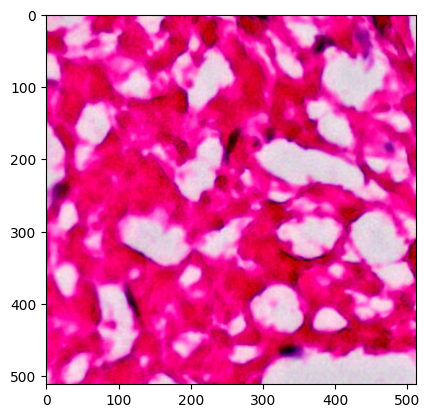

In [23]:
plt.imshow(sample_image.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.show()

In [24]:
# 设置 logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 设定设备
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
vae.to(device)

# 使用现有的 data_dict 和预处理步骤创建数据集和 DataLoader
dataset = GraphImageDataset(data_dict, vae, image_transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=lambda x: x)

# 初始化 GAT 网络（输入维度 50，输出维度 128）
gat_model = GATNetwork(in_channels=50, hidden_channels=128, out_channels=128, heads=4, dropout=0.2).to(device)
# 初始化优化器，仅更新 GAT 参数
optimizer = torch.optim.Adam(gat_model.parameters(), lr=1e-3)

# 开始训练 CLIP 对比学习模块（示例训练 5 个 epoch）
logger.info("开始训练 CLIP 模型（仅更新 GAT 参数）...")
trained_gat = train_clip(vae, gat_model, dataloader, optimizer, device, epochs=5)


Epoch 1/5:   0%|          | 0/169 [00:00<?, ?it/s]

Loading images for data point 3/169:   0%|          | 0/3105 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x128 and 64x16384)